# P4W5: Meta-heuristieken - deel 2

In [1]:
import math
import numpy as np
from inspyred import ec
from random import Random

## 1. Genetic Algorithm

In [2]:
def generate(random = None, args = None):   # genereert 1 individu
    size = args.get('num_inputs',2)    # num_inputs is passed as parameter in evolve fc
    return np.random.uniform(low=-5.12, high=5.12, size=size)

def evaluate(candidates, args = None):
    fitness = []
    for candidate in candidates:
        sum = 10 * len(candidate)
        for i in range(0,len(candidate)):
            sum = sum + (candidate[i]**2 - 10 * math.cos(2*math.pi*candidate[i]))
        fitness.append(sum)
    return fitness

[-0.00756007  0.00764534] : 0.022930956243973455


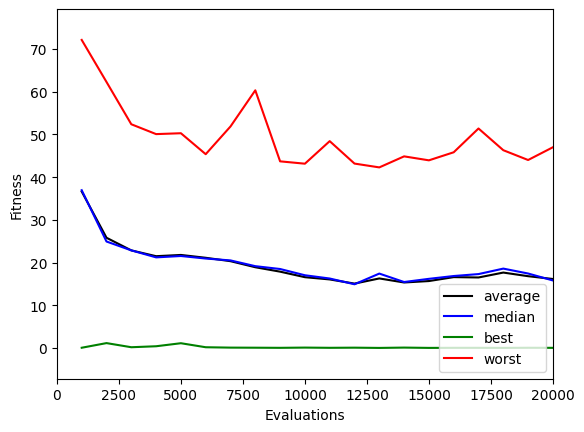

In [3]:
rand = Random()
ga = ec.GA(rand)
ga.terminator = ec.terminators.evaluation_termination  # wanneer stoppen: na max_evaluations
#ga.variator = [ec.variators.n_point_crossover, ec.variators.bit_flip_mutation]  # als 0-1 vector
ga.variator = [ec.variators.arithmetic_crossover, ec.variators.gaussian_mutation] # als real: crosover = gemiddelde van ouders, mutation = kleine afwijking
ga.observer = ec.observers.plot_observer  # toevoegen als je plot wil
population = ga.evolve(
    generator=generate,
    evaluator=evaluate,
    selector = ec.selectors.fitness_proportionate_selection, # voor roulettewiel
    #selector = ec.selectors.tournament_selection,  # voor tournament
    pop_size=1000,  # population size
    maximize=False,  # zoek je max of min?
    bounder=ec.Bounder(-5.12, 5.12),
    max_evaluations=20000,
    mutation_rate=0.25,
    num_inputs=2)  # eigen gedefinieerde parameter
population.sort(reverse=True) # dan is 1ste de beste van de laatste populatie
print(population[0])

## 3. Traveling salesman

In [4]:
distance_matrix = np.array([[0, 100, 125, 100,  75],
                            [100, 0,  50,  75, 100],
                            [125, 50,  0, 100, 125],
                            [100, 75, 100,   0, 50],
                            [75, 100, 125,  50,  0]]) 
distance_matrix = distance_matrix.reshape([25])
distance_matrix

array([  0, 100, 125, 100,  75, 100,   0,  50,  75, 100, 125,  50,   0,
       100, 125, 100,  75, 100,   0,  50,  75, 100, 125,  50,   0])

In [5]:
# route definieren als 0-1 verctor
route = np.array([[0, 1, 0, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 1],
                  [1, 0, 0, 0, 0]]) 
route = route.reshape([-1]) # omvormen naar 1-dimensionale array
route

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0])

In [6]:
def obj_func(solution, weights):
    n=int(math.sqrt(len(solution)))
    #leave each city once
    leaveOK=np.empty((n,1), dtype=int)
    for i in range(0,n):
        index = range(i,n*n, n)
        leaveOK[i] = 0
        for j in index:
            leaveOK[i] = leaveOK[i] + solution[j]
    #Arrive in each city once
    arriveOK=np.empty((n,1), dtype=int)
    for i in range(0,n):
        index = range(i*n,(i+1)*n, 1)
        arriveOK[i] = 0
        for j in index:
            arriveOK[i] = arriveOK[i] + solution[j]
    #Never stay in a city
    index = range(0,n*n, n+1)
    notStayingOK = 0
    for j in index:
        notStayingOK = notStayingOK + solution[j]
    #No subloops or infinite loop but one loop with lenght n
    loop_length = 0
    city=0
    in_loop = True
    while(in_loop & (loop_length < n+1)):
        loop_length = loop_length + 1
        index = range(city*n,(city+1)*n, 1) # row of city
        next_city = 0
        while ((solution[index[next_city]] == 0) & (next_city < n-1)): next_city=next_city+1
        in_loop = (next_city != 0) & (solution[index[next_city]] == 1)
        city = next_city
    #Test if 4 conditions are fulfilled
    if ((notStayingOK == 0) & (np.min(arriveOK) == 1) & (np.max(arriveOK) == 1) & (np.sum(arriveOK) == n)
            & (np.min(leaveOK) == 1) & (np.max(leaveOK) == 1) & (np.sum(leaveOK) == n)
            & (loop_length == n)):
        score=np.sum(np.multiply(solution, weights))  # value objective function
    else:
        score=1000*n + np.sum(np.multiply(solution, weights)) #not a vallid solution, so very bad value for the objective function
    return score

In [7]:
def generate(random = None, args = None):
    size = args.get('num_cities',5)
    solution = np.zeros(size*size,dtype=int)
    for i in range (0, size):
        j = np.random.randint(low=0, high=size)
        solution[i*size+j]=1 # voldoet enkel aan 1ste randvoorwaarde
    return solution.tolist()

def evaluate(candidates, args = None):
    weights = args.get('distance_matrix')
    fitness = []
    for candidate in candidates:
        fitness.append(obj_func(candidate,weights))
    return fitness

In [8]:
rand = Random()
ga = ec.GA(rand)
ga.terminator = ec.terminators.evaluation_termination
ga.variator = [ec.variators.n_point_crossover, ec.variators.bit_flip_mutation]  
population = ga.evolve(
    generator=generate,
    evaluator=evaluate,
    selector = ec.selectors.fitness_proportionate_selection,
    pop_size=1000,
    maximize=False,
    bounder=ec.Bounder(0, 1),
    max_evaluations=1000,
    mutation_rate=0.01,
    num_cities=5,  # zelf gedefinieerde parameter
    distance_matrix=distance_matrix)  # zelf gedefinieerde parameter
population.sort(reverse=True)
print(population[0])

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0] : 375
